<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/DAT264x_Identifying_Appliances_from_Energy_Use_Spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
root = os.getcwd()
print(root)
print(os.listdir())

In [0]:
#pip install keras==2.2.3

In [0]:
import numpy as np
import warnings;warnings.simplefilter('ignore')
from numpy import array
import keras
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from tqdm import tqdm_notebook as tqdm
import os
import seaborn as sns
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import KFold
from PIL import Image 

Using TensorFlow backend.


# Load train

In [0]:
train_images = []
train_idxs = []
train_labels = []
train_data_path = root + '/' +'train'

# Load img
for file_name in tqdm(os.listdir(train_data_path)):
  #convert
  img = Image.open(train_data_path+'/'+file_name).convert('L') 
  #append
  train_images.append(img)
  train_idxs.append(file_name.split('_')[0])

train = pd.DataFrame(index = train_idxs)
train.index.name = 'id'
train.index = train.index.astype('int64')
train['img'] = train_images

#labels
labels_path = root + '/' + 'train_labels.csv'
train_labels = pd.read_csv(labels_path,index_col=0)

#merge
train = train.join(train_labels)

#handle
img_1s = train[::2] # 0 ~ end step 2
img_2s = train[1::2]# 1 ~ end step 2 
train = img_1s
train['img2'] = img_2s['img']
train = train[['img','img2','appliance']]
print(train.shape)
train.head()


(576, 3)


,img,img2,appliance
id,,,
1000,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...,4
1001,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...,9
1002,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...,4
1003,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...,9
1004,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...,6


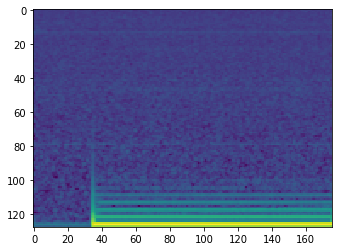

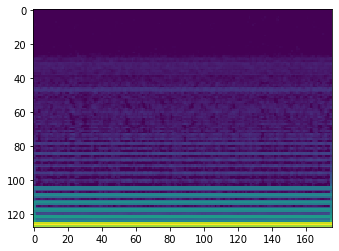

In [0]:
for i in ['img','img2']:
    plt.imshow(train[i].iloc[0])
    plt.show()

# Load test

In [0]:
test_images = []
test_idxs = []
test_data_path = root + '/' +'test'

for file_name in tqdm(os.listdir(test_data_path)):
  #convert
  img = Image.open(test_data_path + '/' + file_name).convert('L')
  #append
  test_images.append(img)
  test_idxs.append(file_name.split('_')[0])

test = pd.DataFrame(index=test_idxs)
test.index.name = 'id'
test.index = test.index.astype('int64')
test['img'] = test_images
test = test.sort_index()

#handle
img_1s = test[::2] # 0 ~ end step 2
img_2s = test[1::2]# 1 ~ end step 2 
test = img_1s
test['img2'] = img_2s['img']
test = test[['img','img2']]
print(test.shape)
test.head()


(384, 2)


,img,img2
id,,
1576,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...
1577,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...
1578,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...
1579,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...
1580,<PIL.Image.Image image mode=L size=176x128 at ...,<PIL.Image.Image image mode=L size=176x128 at ...


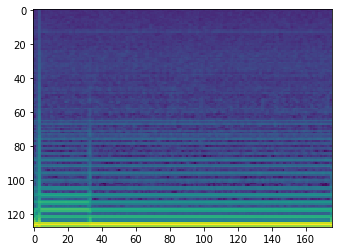

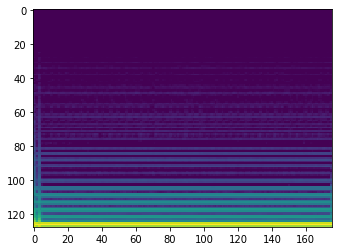

In [0]:
for i in ['img','img2']:
    plt.imshow(test[i].iloc[0])
    plt.show()

# count class

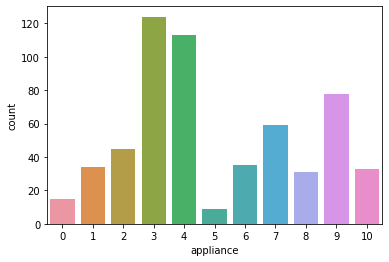

In [0]:
Y_train = train['appliance']
sns.countplot(Y_train)

# count weight

In [0]:
class_weight = 1/(Y_train.value_counts()/len(Y_train))
class_weight = class_weight.to_dict()
class_weight

{3: 4.64516129032258,
 4: 5.097345132743363,
 9: 7.384615384615385,
 7: 9.76271186440678,
 2: 12.8,
 6: 16.45714285714286,
 1: 16.941176470588236,
 10: 17.454545454545457,
 8: 18.58064516129032,
 0: 38.4,
 5: 64.0}

# img to numpy

In [0]:
def to_numpy(imgs):
    h ,w ,c =  img_to_array(imgs.iloc[0]).shape
    X = np.array([img_to_array(img).reshape(1,h,w,c) for img in imgs])
    X = X.astype('float64')
    X = X.reshape(-1,h,w,c)
    X = X / 255.0
    return X

# get Fold data

In [0]:
def get_Fold_data(df,Fold_num):
    
    #切n份
    kf = KFold(n_splits = 5 ,random_state = 42)
    Folds = {}
    for ind,train_val_index in enumerate(kf.split(df.index)):
        Folds[ind] = train_val_index
    
    # get the Fold
    train_index ,val_index = Folds[Fold_num]
    
    # split train and val
    train = df.iloc[train_index]
    val = df.iloc[val_index]
    
    # features extraction
    X_train = features_extraction(train)
    X_valid = features_extraction(val)
    
    # one hot y
    Y_train = np_utils.to_categorical(train['appliance'],num_classes = 11)
    Y_valid = np_utils.to_categorical(val['appliance'],num_classes = 11)
    
    return X_train,X_valid,Y_train,Y_valid

# features_extraction

In [0]:
def features_extraction(data):
    X1 ,X2 = to_numpy(data['img']) ,to_numpy(data['img2'])
    X_stack = np.dstack([X1,X2])
    num_sample ,h,w,c = X_stack.shape
    return X_stack.reshape(-1,h,w,c)

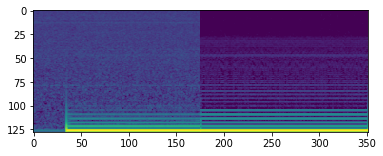

In [0]:
h,w,c = features_extraction(train)[0].shape
plt.imshow(features_extraction(train)[0].reshape(h,w))

# define model

In [0]:
def create_model(input_shape,num_classes):
    model = Sequential()
    
    #CONV 3x3x32 => RELU => NORMALIZATION => MAX POOL 3x3 block
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    #CONV 3x3x64 => RELU => NORMALIZATION => MAX POOL 2x2 block
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #CONV 3x3x128 => RELU => NORMALIZATION => MAX POOL 2x2 block
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #FLATTEN => DENSE 1024 => RELU => NORMALIZATION block
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    #final DENSE => SOFTMAX block for multi-label classification
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [0]:
input_shape = features_extraction(train).shape[1:]
print(input_shape)
a = create_model(input_shape,11)
a.summary()

(128, 352, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 352, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 352, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 352, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 117, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 117, 64)       18496     
_________________________________________________________________
activation_2 (Activation)    (None, 42, 117, 64)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 42, 117, 64)       256    

# define callback

In [0]:
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 30,
                   mode = 'min',
                   restore_best_weights = True)

# train loop

In [0]:
def train_and_test_loop(train,test):
    
    accs = {}
    test_preds = {}
    X_test = features_extraction(test)
    
    # walk Fold 
    for Fold_num in range(5):
        
        # get Fold data
        X_train,X_valid,Y_train,Y_valid = get_Fold_data(train,Fold_num)
        
        # fit model
        model = create_model(X_train.shape[1:],11)
        history = model.fit(X_train,
                            Y_train,
                            batch_size = len(X_train),
                            epochs = 1000,
                            validation_data = (X_valid,Y_valid),
                            verbose = 1,
                            callbacks = [es],
                            class_weight = class_weight)
    
        # log validation acc
        val_pred_argmax = np.argmax(model.predict(X_valid),axis = 1) 
        val_true_argmax = np.argmax(Y_valid,axis = 1) 
        accs[Fold_num] = accuracy_score(val_true_argmax,val_pred_argmax)
        
        # predict on test
        test_preds[Fold_num] = model.predict(X_test) 
    return accs ,test_preds

In [0]:
accs,test_preds = train_and_test_loop(train,test)

Train on 460 samples, validate on 116 samples
Epoch 1/1000
460/460 [==============================] - 7s 15ms/step - loss: 33.6161 - acc: 0.1174 - val_loss: 7.9810 - val_acc: 0.4397
Epoch 2/1000
460/460 [==============================] - 0s 842us/step - loss: 35.3491 - acc: 0.4891 - val_loss: 3.7908 - val_acc: 0.5948
Epoch 3/1000
460/460 [==============================] - 0s 836us/step - loss: 15.3907 - acc: 0.7196 - val_loss: 3.2723 - val_acc: 0.5345
Epoch 4/1000
460/460 [==============================] - 0s 832us/step - loss: 7.3514 - acc: 0.8261 - val_loss: 2.7254 - val_acc: 0.5431
Epoch 5/1000
460/460 [==============================] - 0s 848us/step - loss: 4.7628 - acc: 0.8957 - val_loss: 2.5370 - val_acc: 0.5690
Epoch 6/1000
460/460 [==============================] - 0s 835us/step - loss: 3.0788 - acc: 0.9152 - val_loss: 2.5308 - val_acc: 0.5948
Epoch 7/1000
460/460 [==============================] - 0s 828us/step - loss: 2.3700 - acc: 0.9391 - val_loss: 2.5253 - val_acc: 0.5862


In [0]:
accs

{0: 0.853448275862069,
 1: 0.8173913043478261,
 2: 0.7913043478260869,
 3: 0.8,
 4: 0.808695652173913}

In [0]:
#mean acc
np.mean(list(accs.values()))

0.8141679160419791

# submit

In [0]:
sum_preds = test_preds[0]+test_preds[1]+test_preds[2]+test_preds[3]+test_preds[4]
print(sum_preds.shape)

(384, 11)


In [0]:
final_preds = [np.argmax(i) for i in sum_preds]
final_preds[:5]

[9, 5, 4, 2, 8]

In [0]:
submit = pd.read_csv('submission_format.csv')
submit['appliance'] = final_preds
submit.head()

,id,appliance
0,1576,9
1,1577,5
2,1578,4
3,1579,2
4,1580,8


In [0]:
submit.to_csv('submit_1205_2.csv',index=False)